In [1]:
import os
import datetime
import torch
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import wandb
import sys
import matplotlib.pyplot as plt
import pickle

# from RMDT_model.RMDT import mem_transformer_v2

import os
import sys
sys.path.append("../../")

from VizDoom.VizDoom_src.utils.get_vizdoom_dataset import get_dataset


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


# Load VizDoom-Two-Colors data

In [2]:
# train_pickle_file = 'VizDoom/VizDoom_data/train_VizDoom_Two_Colors_Column_disappear_delay_45_no_walls_agent_p1_01.pickle'
val_pickle_file = '../../VizDoom/VizDoom_data/val_VizDoom_Two_Colors_Column_disappear_delay_45_no_walls_agent_p1_01.pickle'

# DATA2_train = []
DATA2_val = []

# with open(train_pickle_file, 'rb') as f:
#     while True:
#         try:
#             data = pickle.load(f)
#             DATA2_train.append(data)
#         except EOFError:
#             break
            
with open(val_pickle_file, 'rb') as f:
    while True:
        try:
            data = pickle.load(f)
            DATA2_val.append(data)
        except EOFError:
            break
            
# DATA_train = {}
DATA_val = {}

# for key in tqdm(DATA2_train[0].keys()):
#     DATA_train[key] = [d[key] for d in DATA2_train]
    
for key in tqdm(DATA2_val[0].keys()):
    DATA_val[key] = [d[key] for d in DATA2_val]

100%|██████████| 5/5 [00:00<00:00, 21098.11it/s]


In [3]:
print(DATA_val.keys())
# print(len(DATA_train['obs']))
print(len(DATA_val['obs']))

dict_keys(['obs', 'action', 'reward', 'done', 'is_red'])
256


In [4]:
DATA_val['reward'][31]

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 1.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.

tensor([15.5415, 21.6142, 16.7178]) tensor([17.3943, 20.8999, 12.8508])
tensor([ 3.7793e-07,  8.0701e-07, -1.0920e-07]) tensor([1.0000, 1.0000, 1.0000])


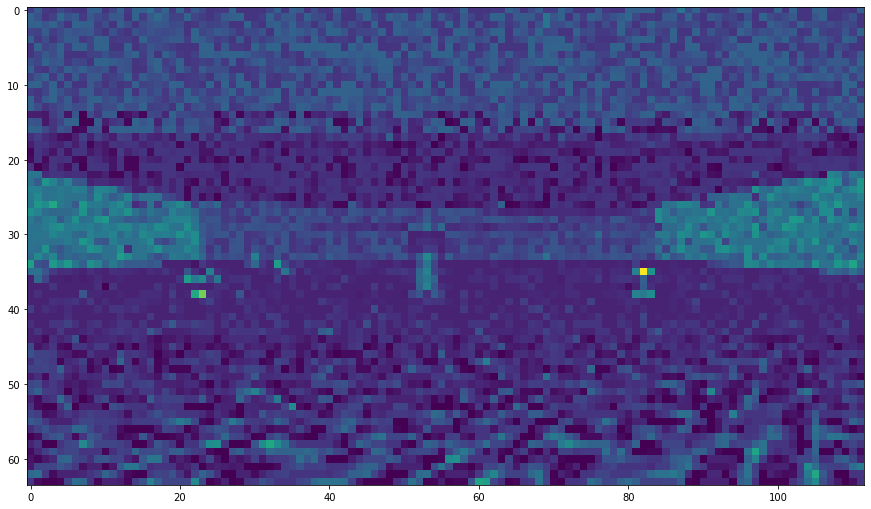

In [19]:
val_dataset = get_dataset(DATA_val, gamma=1.0, max_length=3*30, normalize=True)
plt.figure(figsize=(15,10))
plt.imshow(val_dataset[31][0][15][2])
plt.show()

In [71]:
test = torch.tensor([[[1, 1, 1],
             [2,2,2],
             [3,3,3]],

             [[6, 6, 6],
             [7,7,7],
             [8,8,8]]], dtype=float)

std = torch.std(test, dim=[0, 1])
mean = torch.mean(test, dim=[0, 1])

In [72]:
test1 =  (test-mean)/std#(test - mean[None, :, None]) / std[None, :, None]
test2 =  (test - mean[None, :, None]) / std[None, :, None]

In [73]:
test1 - test2

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=torch.float64)

In [6]:
# a = 0``
# b = 1
# if a == 0 \
#     and b == 1:
#     print("rofl")